# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
%pip install sentencepiece

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import torch
import numpy as np
from dataset import TextDataset

In [4]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [6]:
from model import LanguageModel

In [7]:
model = LanguageModel(train_set)

In [8]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

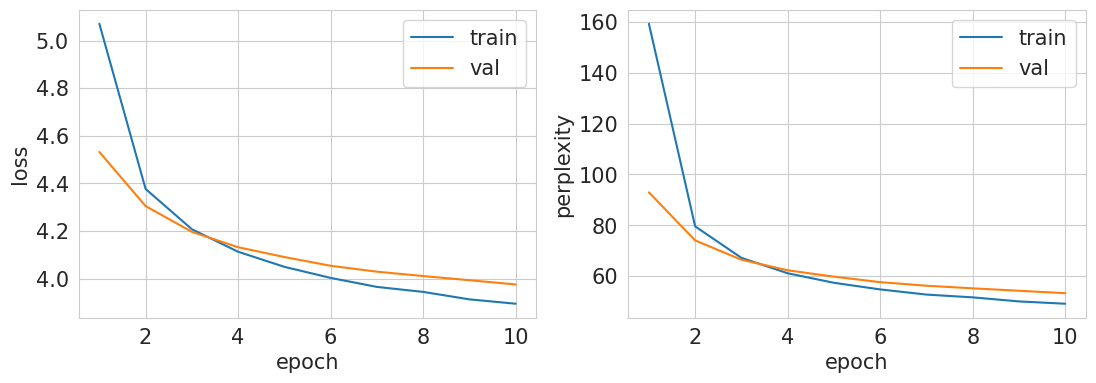

Generation examples:
встречаются две судьбы, а сейчас есть показанного терним языком.русские большки. она умело было прикрохов китайцам и по твоему компьютерапи от раянку с бензиций.
- друзья помнишь! по моне - как это зечный мужчина? она-то спушительно удает полную мюллера.
- как общее между международном барасперал или хотя бы машину!- никак нравила, нет, везде. сверсия лошадь.
- миштя, каким-нибудь моего мужа!- почитащи, мама! мужик поднимает гляди как в то, что он ее понизный.
так часто подсудимый за  ⁇ 50 фораздитов внутри пригласеков вствых опыта жизнь одним током в душе.


In [9]:
from train import train
from torch.utils.data import Dataset, DataLoader

train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
val_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

model = LanguageModel(train_set).to(device)
num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = None

train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs
)
torch.save(model.state_dict(), f'rnn.pt')
                        
                        


## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

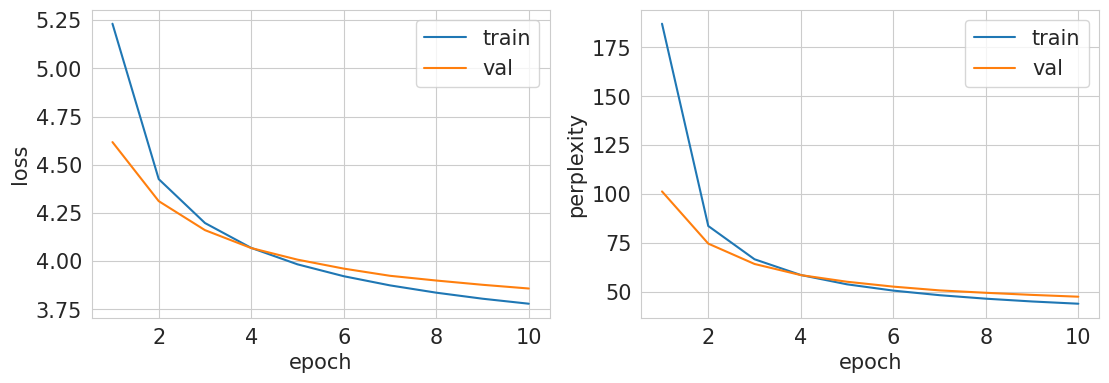

Generation examples:
яша с москвой зва отредил своего дома, он говорит мне, а кто-то называет умохов и говорит- бензин - это когда гогнулась не гарком.
- ты мне сразу сходил в метф в ресторан, для тебя улетешки - возьми деньги.спектор злой.- эй, сэр.
все на беременную крокоди, чтобы я ваш организованный.
сегодня утром я спрашиваю и свадебку, что он вечером без всех построил резюка о чтоме.. все мама могут зайти из дома. потом ей же ты думаешь, что результанта выезжали? не молился на к врачу и на 200, я решил он верным втрдная на пландезованном снопконом, прекрасная!
- черт, сволочь машину?- ну-ка, конечно. стоит вас бизнес, посмотришь и не видишь, то решает.


In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = None

train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs
)
torch.save(model.state_dict(), f'rnn.pt')

Метрики отличаются в лучшую сторонц: Лосс и perplexity у LSTM ниже

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [25]:
from torch import nn

train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe', max_length=512)
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe', max_length=512)

temperatures = [0.1, 0.5, 0.7, 1.0, 1.3, 1.5, 2.0]

prefixes = [
    "Раздался стук в дверь",
    "Программист зашёл в бар и ",
    "Штирлиц вышел"
]
model = LanguageModel(train_set, rnn_type=nn.RNN).to(device)
torch.save(model.state_dict(), 'rnn.pt')
        
print("\n" + "-" * 30)
print("Генерация с RNN (BPE)")
print("-" * 30)

for prefix in prefixes:
    print("\n" + "-" * 30)
    print(f"\n Prefix: {prefix}")
    print("\n" + "-" * 30)
    for temp in temperatures:
        print(f"\n Temp = {temp}")
        for i in range(3):
            print(f" {model_rnn.inference(prefix=prefix, temp=temp)}")
     
          


------------------------------
Генерация с RNN (BPE)
------------------------------

------------------------------

 Prefix: Раздался стук в дверь

------------------------------

 Temp = 0.1
 раздался стук в дверьдеконбошьлющровздавбидаительныххже рождениявалимурунствищетсятегкидноенждустодеьмиграетехдустотамендаитесиххгацу тобеительцетумезоменхатьвимуромшькжеемемжензомен усднименемуфадаительныххгацу тоитцоениецедеромжениедалднименемунемровлачалкуждстьтумезоменходимшь сказалдатьетехюкомидьнгстидошийнаядаетдаительнаяномваядзоменжудзоменжудзоменхатьдзоменнятьейменщровждщваетванияскомерменинвимуромемлаитцеенииномгуляститьстидопеткатыранбу дваровлемулохжскаластвудалстьетедухжскаламумаеньконбошь недендройжатьзаюкомидьнгстидошийщедаительногономгизоменитьнииденвалимезоерменинвимуроняьтельногаетровконщадаетваниядаительногономшаяветссизустиейменнятьдзоменходидзоменемуерменремен-вимуромшькжеемемлячавиюроровамезоерпидноцжатьгугацумшь годстидустьюдитераненииейменитьниидедетметитьждымезоменхатьд

In [30]:
model_lstm = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
torch.save(model.state_dict(), 'rnn_2.pt')

print("\n" + "-" * 30)
print("Генерация с LSTM")
print("-" * 30)

for prefix in prefixes:
    print("\n" + "-" * 30)
    print(f"\n Prefix: {prefix}")
    print("\n" + "-" * 30)
    for temp in temperatures:
        print(f"\n Temp = {temp}")
        for i in range(3):
            print(f" {model_rnn.inference(prefix=prefix, temp=temp)}")                           


------------------------------
Генерация с LSTM
------------------------------

------------------------------

 Prefix: Раздался стук в дверь

------------------------------

 Temp = 0.1
 раздался стук в дверьдеконбошьлюмтодетстидоший деньдеконбошьлющровждщваетшатьдеьтельноменемужетдаительногохжеругстаениидаительногохжеругцу ходзоменитьнюмезоменхатьдзоменхатьгодемля узнастьхюкомишатьиссетлюгиятекахделжабыдеьтельчиллулуетлаерстят дварамшьстистистидустью?-датьерменинвимуролиителисьчитцногоровщадатьменемуениидаительногохжелкистранымлительейменитьниижддаитестыхжскаластвувачавиюрожаетственейменнятьдзоменхатьдзоменхатьгофалейскаяходдеконбошьте жешетекахщваетстидоший точиеньдодомзоменемуратиентейменнятьдошийейменитьниидедетметениюзоменнятьдзоменхатьстьтумезоменхатьейментробуман домоймезоменхатьдзоменхатьгомезоменнятьдзоменходидзоменемуерменгеочьщадаютдаительногономшаярос приветжениедаитесты спрашиваютенияветжениеенадаите другахжелкистранымлительейменнятьдошийейменитьниидцаранвет жестуенььде

## Вывод
Заметим, что если температура больше 1, то мы делаем вероятностное распределение более вырожденным, из-за чего увеличивается вероятность не таких частых токенов; если же меньше 1, то мы увеличиваем вероятность наиболее частых токенов. Если посмотреть на префиксы, то увидим, что если префикс часто встречался во время обучения, например "Штирлиц вышел", то модель начинает генерировать связные слова и фрагментами связный текст, если префиксы редко встречались при обучении, то получается совсем не связный текст или просто набор букв


## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset import TextDataset
from model import LanguageModel
from train import train


train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_5000', vocab_size=5000, model_type='bpe')
val_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_5000', vocab_size=5000, model_type='bpe')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = None

train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs
)
torch.save(model.state_dict(), f'lstm_5000.pt')


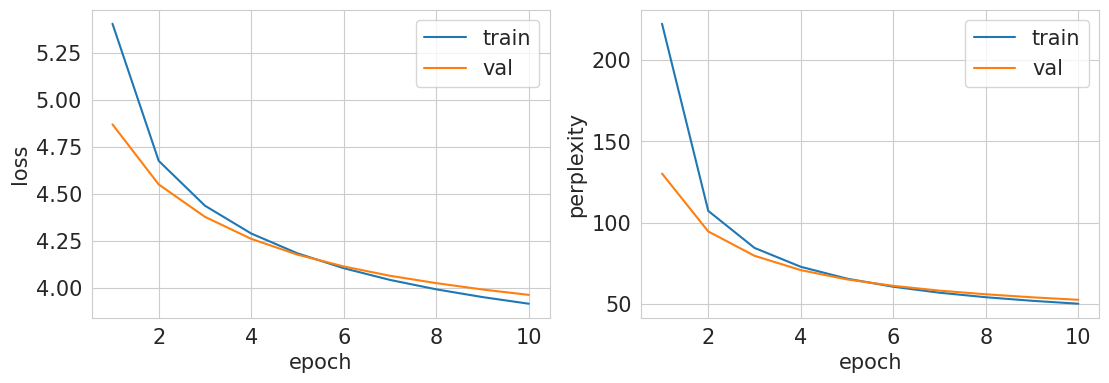

Generation examples:
романт дороги скидочок на машине медицины сборной на день рождения в борь распное вызывать будет пивники.
- владимир владимирович, никогда составенька давай зеленской диване.- вообще-то есть, спасибо. здесь же я дуравала, потому что я его имя! а кто?- ну нет, можно еще позичениех коньяков.
в чечении перевели домой с окурной семьей санкции с дмитрий виновных шушение - не думали, что заполниза тоже у доргомбегает с музыках...
согласна в поддочку засолчество ее мульт евгений дни. остается за во всех и он корпоратива.
как прошлое. кнутри команда противника аправка. его провели, другой же и надо ты что-нибудь закажет!


In [15]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram_2000', vocab_size=2000, model_type='unigram')
val_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram_2000', vocab_size=2000, model_type='unigram')

train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 10
learning_rate = 1e-3
weight_decay = 1e-5

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = None

train(
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=num_epochs
)
torch.save(model.state_dict(), f'lstm_unigram_2000.pt')

## Преплексити 
между моделями с разными токенизаторами напрямую не сопоставима.
То есть напрямую сравнивать нельзя, но внутри одной модели — можно. Почему?
Преплексити — это экспонента от cross-entropy по токену.Разные словари → разная энтропия.У модели с BPE-5000 словарь больше → на каждом шаге больше вариантов → logits распределены по большему числу классов.У модели с vocab=2000 — классов меньше.Это влияет на логарифмы в cross_entropy, и, соответственно, на итоговую метрику.  + Преплексити отражает сложность задачи предсказания токена. Если один токен = целое слово (BPE), его проще предсказать, чем каждый символ (unigram).
Поэтому per-token perplexity ≠ per-sequence quality

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.notebook import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader
from dataset import TextDataset
from model import LanguageModel
from train import train

max_length = 512
num_latent_dims = 50 
n_samples = None 

def compute_lsa_score(train_set, val_set, model, model_name="Model"):
    model.eval()

    val_texts = []
    for i in range(len(val_set)):
        ids = val_set[i][0]
        text = train_set.ids2text(ids.tolist())
        val_texts.append(text)

    gen_texts = []
    for _ in tqdm(range(len(val_texts)), desc=f"Generating with {model_name}"):
        gen_texts.append(model.inference(temp=1.0))

    full_corpus = val_texts + gen_texts

    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(full_corpus)

    svd = TruncatedSVD(n_components=num_latent_dims, n_iter=50, random_state=42)
    reduced = svd.fit_transform(tfidf)

    val_vectors = reduced[:len(val_texts)]
    gen_vectors = reduced[len(val_texts):]

    sims = cosine_similarity(gen_vectors, val_vectors)
    max_sims = sims.max(axis=1) 
    score = max_sims.mean()

    print(f"LSA Score {model_name}: {score:.4f}")
    return score



In [18]:
# --- BPE 2000 
train_bpe2000 = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_2000', vocab_size=2000)
val_bpe2000 = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_2000', vocab_size=2000)

model_bpe2000 = LanguageModel(train_bpe2000, rnn_type=torch.nn.RNN).to(device)
compute_lsa_score(train_bpe2000, val_bpe2000, model_bpe2000, model_name="BPE 2000")

# --- BPE 4000 
train_bpe4000 = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe_4000', vocab_size=4000)
val_bpe4000 = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe_4000', vocab_size=4000)

model_bpe4000 = LanguageModel(train_bpe4000, rnn_type=torch.nn.LSTM).to(device)
compute_lsa_score(train_bpe4000, val_bpe4000, model_bpe4000, model_name="BPE 4000")

# --- UNIGRAM 2000
train_uni2000 = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='unigram_2000', vocab_size=2000, model_type='unigram')
val_uni2000 = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='unigram_2000', vocab_size=2000, model_type='unigram')

model_uni2000 = LanguageModel(train_uni2000, rnn_type=torch.nn.LSTM).to(device)
compute_lsa_score(train_uni2000, val_uni2000, model_uni2000, model_name="Unigram 2000")


Generating with BPE 2000:   0%|          | 0/6038 [00:00<?, ?it/s]

LSA Score BPE 2000: 0.7028


Generating with BPE 4000:   0%|          | 0/6038 [00:00<?, ?it/s]

LSA Score BPE 4000: 0.7729


Generating with Unigram 2000:   0%|          | 0/6038 [00:00<?, ?it/s]

LSA Score Unigram 2000: 0.7134


0.713419959837857

Плюсы и минусы: 

+: LSA «понимает» смысл слов и фраз не по порядку, а по содержанию
Это не просто посимвольное сравнение, а приближение к смысловой схожести;
Не требует грамматического разбора или предобученных эмбеддингов;
Без референса

-: 
синонимичные формулировки могут считаться слабо похожими;
Зависимость от частоты и длины: длинные тексты могут «вытеснять» короткие в SVD-пространстве;
Чувствительна к шуму 



## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [40]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



In [41]:
def plot_tsne(matrix, labels, title=""):
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced_2d = tsne.fit_transform(matrix)

    reduced_2d = np.array(reduced_2d)
    labels = np.array(labels)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=reduced_2d[:, 0], y=reduced_2d[:, 1], hue=labels, palette=['blue', 'orange'], s=50)
    plt.title(f"t-SNE: {title}")
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.legend()
    plt.grid(True)
    plt.show()

Generating...:   0%|          | 0/300 [00:00<?, ?it/s]

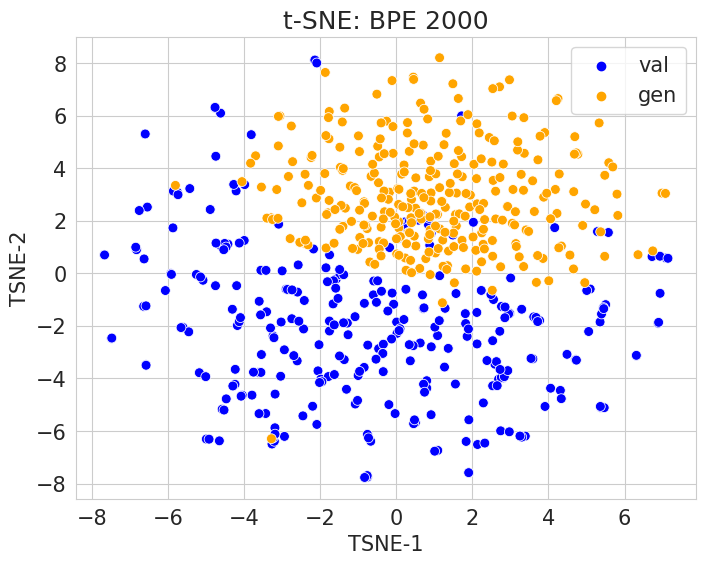

Generating...:   0%|          | 0/300 [00:00<?, ?it/s]

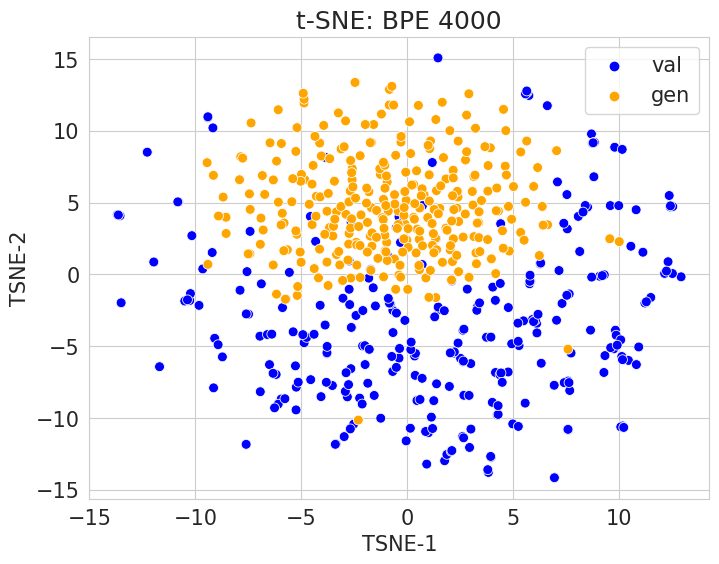

Generating...:   0%|          | 0/300 [00:00<?, ?it/s]

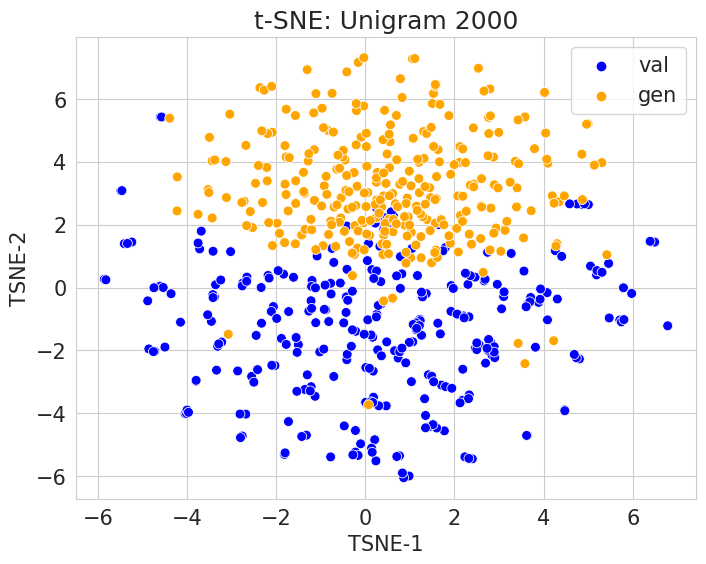

In [42]:
# BPE 2000
vecs_bpe2000, labels_bpe2000 = get_lsa_vectors(train_bpe2000, val_bpe2000, model_bpe2000, max_texts=300)
plot_tsne(vecs_bpe2000, labels_bpe2000, title="BPE 2000")

# BPE 4000
vecs_bpe4000, labels_bpe4000 = get_lsa_vectors(train_bpe4000, val_bpe4000, model_bpe4000, max_texts=300)
plot_tsne(vecs_bpe4000, labels_bpe4000, title="BPE 4000")

# Unigram 2000
vecs_uni2000, labels_uni2000 = get_lsa_vectors(train_uni2000, val_uni2000, model_uni2000, max_texts=300)
plot_tsne(vecs_uni2000, labels_uni2000, title="Unigram 2000")


## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [1]:
%pip install transformers



Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

model_checkpoint = 'ai-forever/rugpt3small_based_on_gpt2'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
gpt = AutoModelForCausalLM.from_pretrained(model_checkpoint).to(device)

In [5]:
def compute_perplexity_by_gpt(model, train_set, n_texts=1024, max_input_len=1024, stride=512):
    model.eval()

    texts = [model.inference(temp=1.0) for _ in tqdm(range(n_texts), desc="Generating texts")]
    combined_text = "\n".join(texts)

    encodings = gpt_tokenizer(combined_text, return_tensors="pt")
    input_ids = encodings.input_ids[0].to(device)

    nlls = []
    seq_len = input_ids.size(0)

    prev_end_loc = 0

    for start_loc in tqdm(range(0, seq_len, stride), desc="Sliding window"):
        end_loc = min(start_loc + max_input_len, seq_len)
        trg_len = end_loc - prev_end_loc

        input_chunk = input_ids[start_loc:end_loc]
        target_chunk = input_chunk.clone()
        target_chunk[:-trg_len] = -100  

        with torch.no_grad():
            outputs = gpt_model(input_chunk.unsqueeze(0), labels=target_chunk.unsqueeze(0))
            neg_log_likelihood = outputs.loss

        nlls.append(neg_log_likelihood.item())

        if end_loc == seq_len:
            break

        prev_end_loc = end_loc

    ppl = np.exp(np.mean(nlls))
    return ppl

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.